<a href="https://colab.research.google.com/github/plaban1981/DEEP-LEARNING-/blob/master/Transfer_Learning_Using_Pretrained_ConvNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. 

We can either use the pretrained model as it is or transfer learning using the pretrained convents. The intuition behind transfer learning is that if this model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. We can leverage these learned feature maps without having to train a large model on a large dataset by using these models as the basis of our own model specific to our task. 

There are 2 scenarios of transfer learning using a pretrained model:

*  Feature Extraction - use the representations of learned by a previous network to extract meaningful features from new samples. We simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that we can repurpose the feature maps learned previously for our dataset. Do we use the entire pretrained model or just the convolutional base? - We use the feature extraction portion of these pretrained convnets (convolutional base) since they are likely to be generic features and learned concepts over a picture. However, the classification part of the pretrained model is often specific to original classification task, and subsequently specific to the set of classes on which the model was trained.

* Fine-Tuning - unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added classifier layers as well as the last layers of the frozen model. This allows us to "fine tune" the higher order feature representations in addition to our final classifier in order to make them more relevant for the specific task involved.

We will follow the general machine learning workflow:

* Examine and understand data

* Build an input pipeline - using Keras ImageDataGenerator as we did in the image classification tutorial

* Compose our model

* Load in our pretrained model (and pretrained weights)

* Stack our classification layers on top

* Train our model

* Evaluate model

# Import Libraries

In [1]:
import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  1.14.0


#Data preprocessing


## Download data - cats_and_dogs_filtered.zip

We will download a filtered version of Kaggle's Dogs vs Cats dataset. Then store the downloaded zip file to the "/tmp/" directory.

In [2]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

68608000/68606236 [==============================] - 0s 0us/step


# Prepare training and validation cats and dogs datasets

## Create the training and validation directories for cats datasets and dog datasets.

In [3]:
base_dir

'/root/.keras/datasets/cats_and_dogs_filtered'

In [0]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [5]:
train_dir

'/root/.keras/datasets/cats_and_dogs_filtered/train'

In [6]:
validation_dir

'/root/.keras/datasets/cats_and_dogs_filtered/validation'

In [7]:
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


##Create Image Data Generator with Image Augmentation

#We will use ImageDataGenerator to rescale the images.

To create the train generator, specify where the train dataset directory, image size, batch size and binary classification mode.

The validation generator is created the same way.

In [0]:
image_size = 160 # All images will be resized to 160x160
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


## Flow training images in batches of 20 using train_datagen generator

In [9]:
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

Found 2000 images belonging to 2 classes.


##  Flow validation images in batches of 20 using test_datagen generator

In [10]:
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 1000 images belonging to 2 classes.


#Create the base model from the pre-trained convnets

 Create the base model from the MobileNet V2 model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. This is a powerful model. 
 
 First, we need to pick which intermediate layer of MobileNet V2 we will use for feature extraction. 
 
 * A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". 
 
The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

## Instantiate an MobileNet V2 model pre-loaded with weights trained on ImageNet. 

By specifying the  **include_top=False**  argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [11]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

W0725 08:00:32.759082 139918746228608 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


9412608/9406464 [==============================] - 0s 0us/step


## Feature extraction

We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

##Freeze the convolutional base

It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting **layer.trainable = False**), we prevent the weights in these layers from being updated during training.

In [0]:
base_model.trainable = False

##Base Model Architecture

In [41]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

# Add a classification head

## Add a few layers on top of the base model:

In [0]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

# Compile the Model

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


These 1.2K trainable parameters are divided among 2 TensorFlow Variable objects, the weights and biases of the two dense layers:

len(model.trainable_varia

In [45]:
len(model.trainable_variables)

2

#Train the model

In [0]:
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [47]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/50
62/62 [==============================] - 9s 151ms/step - loss: 0.5449 - acc: 0.7271 - val_loss: 0.3183 - val_acc: 0.9093
Epoch 2/50
62/62 [==============================] - 7s 117ms/step - loss: 0.1628 - acc: 0.9822 - val_loss: 0.1707 - val_acc: 0.9546
Epoch 3/50
62/62 [==============================] - 7s 116ms/step - loss: 0.0623 - acc: 0.9990 - val_loss: 0.1436 - val_acc: 0.9567
Epoch 4/50
62/62 [==============================] - 7s 117ms/step - loss: 0.0252 - acc: 1.0000 - val_loss: 0.1363 - val_acc: 0.9587
Epoch 5/50
62/62 [==============================] - 7s 118ms/step - loss: 0.0134 - acc: 1.0000 - val_loss: 0.1304 - val_acc: 0.9587
Epoch 6/50
62/62 [==============================] - 7s 116ms/step - loss: 0.0100 - acc: 1.0000 - val_loss: 0.1319 - val_acc: 0.9597
Epoch 7/50
62/62 [==============================] - 7s 115ms/step - loss: 0.0066 - acc: 0.9995 - val_loss: 0.1313 - val_acc: 0.9617
Epoch 8/50
62/62 [==============================] - 7s 116ms/step - loss: 0.

In [0]:
acc= history.history['acc']
val_acc = history.history['val_acc']
loss= history.history['loss']
val_loss = history.history['val_loss']

#Learning curves

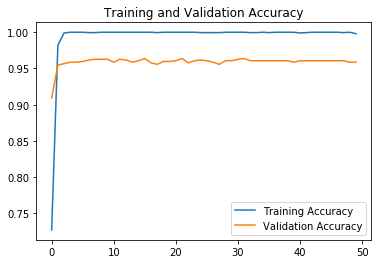

In [49]:
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

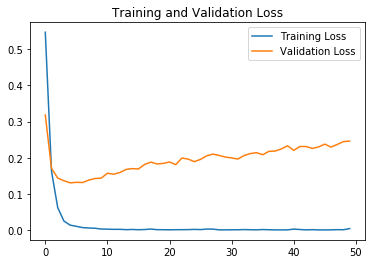

In [50]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#Fine tuning

In our feature extraction experiment, we were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pre-trained model alongside the training of the top-level classifier. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

#Un-freeze the top layers of the model
All we need to do is unfreeze the base_model, and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [0]:
base_model.trainable = True

In [52]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


#Compile the model

Compile the model using a much-lower training rate.



In [0]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


#Continue Train the model

In [56]:
history = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/50
62/62 [==============================] - 14s 229ms/step - loss: 1.6031e-04 - acc: 1.0000 - val_loss: 0.2513 - val_acc: 0.9577
Epoch 2/50
62/62 [==============================] - 8s 130ms/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.3031 - val_acc: 0.9516
Epoch 3/50
62/62 [==============================] - 8s 127ms/step - loss: 2.8922e-04 - acc: 1.0000 - val_loss: 0.2968 - val_acc: 0.9516
Epoch 4/50
62/62 [==============================] - 8s 126ms/step - loss: 1.1775e-04 - acc: 1.0000 - val_loss: 0.2590 - val_acc: 0.9587
Epoch 5/50
62/62 [==============================] - 8s 128ms/step - loss: 1.0426e-04 - acc: 1.0000 - val_loss: 0.2304 - val_acc: 0.9617
Epoch 6/50
62/62 [==============================] - 8s 127ms/step - loss: 3.2467e-04 - acc: 1.0000 - val_loss: 0.2616 - val_acc: 0.9567
Epoch 7/50
62/62 [==============================] - 8s 129ms/step - loss: 7.2376e-05 - acc: 1.0000 - val_loss: 0.2786 - val_acc: 0.9546
Epoch 8/50
62/62 [==============================] -

In [0]:
acc += history.history['acc']
val_acc += history.history['val_acc']

loss += history.history['loss']
val_loss += history.history['val_loss']

#Learning curves

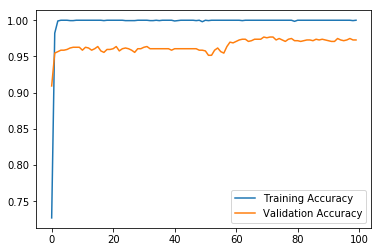

In [61]:
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.show()

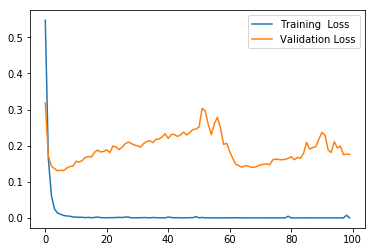

In [62]:
plt.plot(loss,label='Training  Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.show()

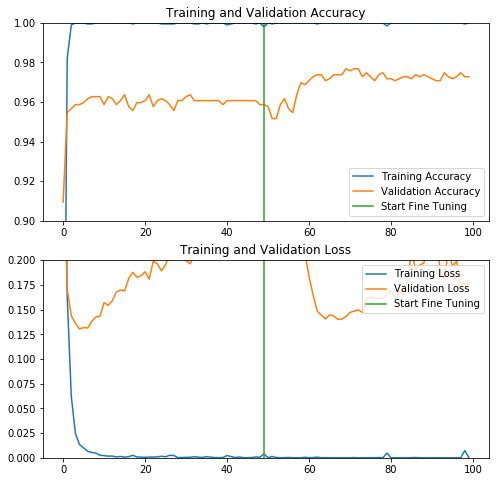

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Key Takeaways 

* Using a pre-trained model for feature extraction - when working with a small dataset, it is common to leverage the features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier are updated during training. In this case, the convolutional base extracts all the features associated with each image and we train a classifier that determines, given these set of features to which class it belongs. 

* Fine-tuning a pre-trained model - to further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, we tune our weights such that we learn highly specified and high level features specific to our dataset. This only make sense when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

## Adding Dropout Layer

In [0]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(0.2),  
  keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [65]:
history = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/50
62/62 [==============================] - 14s 233ms/step - loss: 0.3037 - acc: 0.8709 - val_loss: 0.1198 - val_acc: 0.9617
Epoch 2/50
62/62 [==============================] - 8s 126ms/step - loss: 0.0391 - acc: 0.9990 - val_loss: 0.0859 - val_acc: 0.9698
Epoch 3/50
62/62 [==============================] - 8s 127ms/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0820 - val_acc: 0.9728
Epoch 4/50
62/62 [==============================] - 8s 127ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0810 - val_acc: 0.9748
Epoch 5/50
62/62 [==============================] - 8s 132ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0917 - val_acc: 0.9748
Epoch 6/50
62/62 [==============================] - 8s 134ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0930 - val_acc: 0.9748
Epoch 7/50
62/62 [==============================] - 8s 134ms/step - loss: 5.5602e-04 - acc: 1.0000 - val_loss: 0.0996 - val_acc: 0.9768
Epoch 8/50
62/62 [==============================] - 8s 135ms/step - los

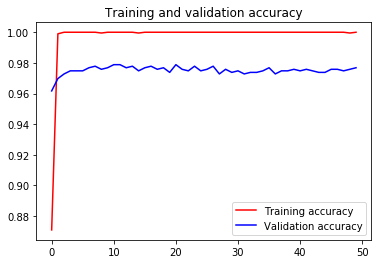

<Figure size 432x288 with 0 Axes>

In [66]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

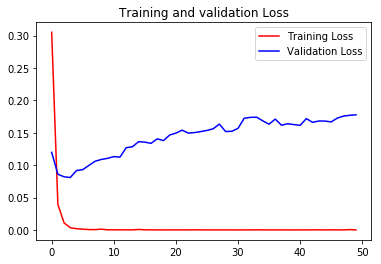

<Figure size 432x288 with 0 Axes>

In [67]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()


plt.show()